In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

In [2]:
def result(predictions):
    predictions = predictions.tolist()
    result_list=[]
    for pred in predictions:
        result = pred // 0.5 * 0.5
        if (pred - result) > 0.25:
            result += 0.5
        if result < 1.0:
            result = 1.0
        if result > 5.0:
            result = 5.0
        result_list.append(result)
    return result_list

# Accuracy score
def accuracy(Ypred, Ytrue):
    Ytrue = Ytrue.tolist()
    accurate = 0
    for i in range(len(Ytrue)):
        if Ytrue[i] == Ypred[i]:
            accurate += 1
    return accurate / len(Ytrue)

def accuracy_range(Ytrue, Ypred):
    Ytrue=Ytrue.tolist()
    accurate_range=0
    for i in range(len(Ytrue)):
        if abs(Ytrue[i] - Ypred[i])<=0.5:
            accurate_range+=1
    return accurate_range/len(Ytrue)

# Total error / total number of points => by average what's the error for each point
def error_rate(Ytrue, Ypred):
    Ytrue=Ytrue.tolist()
    error=0
    for i in range(len(Ytrue)):
        error += abs(Ytrue[i] - Ypred[i])
    return error/len(Ytrue)

## Use 35 features to predict cohesion

In [40]:
df = pd.read_csv("/Users/lokki/Documents/GitHub/Text_Marker/Processed_Data.csv")
df = df.dropna(axis=0)

y_coh = df["cohesion"]
X = df.iloc[:, 7:]
X = X.drop("corrected_text", axis=1)
X["text_standard"].mask(df["text_standard"] == "-", 0, inplace=True)
X["verb_to_adv"].mask(np.isinf(df["verb_to_adv"]), 0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y_coh, test_size=1/4, random_state=42)

In [41]:
pd.set_option("display.max_columns", None)
X_train.describe()
# X_train.columns.values

,number_of_words,stopwords_frequency,av_word_per_sen,punctuations,ARI,freq_of_verb,freq_of_adj,freq_of_adv,freq_of_distinct_adj,freq_of_distinct_adv,sentence_complexity,freq_of_wrong_words,sentiment_compound,sentiment_positive,sentiment_negative,num_of_grammar_errors,num_of_short_forms,Incorrect_form_ratio,flesch_reading_ease,flesch_kincaid_grade,dale_chall_readability_score,text_standard,mcalpine_eflaw,number_of_diff_words,freq_diff_words,ttr,coherence_score,lexrank_avg_min_diff,lexrank_interquartile,freq_of_noun,freq_of_transition,freq_of_pronoun,noun_to_adj,verb_to_adv,phrase_diversity
count,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,430.018752,0.502877,29.892179,0.070443,13.457893,0.105493,0.090935,0.041058,0.058591,0.021476,1.531914,0.017085,0.720081,0.155591,0.058616,25.958745,0.042618,0.063331,65.431456,11.430276,6.601872,10.470849,-16.937197,43.500170,0.104196,0.073276,0.436860,0.471002,0.445249,0.250858,0.043335,0.091760,0.373846,0.413783,0.155793
std,187.798439,0.050080,26.991038,0.024693,13.268479,0.025690,0.022215,0.016236,0.015804,0.008955,0.069824,0.016011,0.605335,0.069141,0.044353,18.603954,0.336336,0.037569,26.704352,10.147929,1.573493,6.778476,38.364674,21.288886,0.033408,0.015700,0.095850,0.189008,0.247037,0.045040,0.014732,0.032583,0.113591,0.215463,0.091976
min,14.000000,0.221176,6.344828,0.000000,1.000000,0.004706,0.010471,0.004751,0.000000,0.000000,1.163762,0.000000,-0.998600,0.000000,0.000000,0.000000,0.000000,0.000000,-489.820000,1.600000,1.090000,0.000000,-832.000000,3.000000,0.028078,0.029574,0.176278,0.000000,0.000000,0.112994,0.002488,0.004854,0.031250,0.029412,0.002232
25%,298.000000,0.470588,18.185185,0.053763,8.000000,0.088292,0.076503,0.029545,0.047863,0.015385,1.487588,0.006522,0.920700,0.107000,0.025000,14.000000,0.000000,0.037736,60.210000,7.100000,6.020000,7.000000,-20.900000,29.000000,0.080000,0.062773,0.375931,0.347232,0.267903,0.219766,0.033223,0.069231,0.295775,0.277778,0.091432
50%,401.000000,0.503448,23.043478,0.070088,10.000000,0.104839,0.089888,0.039604,0.057348,0.020478,1.532763,0.012077,0.989000,0.148000,0.049000,21.000000,0.000000,0.054475,70.260000,9.100000,6.470000,9.000000,-7.300000,40.000000,0.100223,0.072178,0.421686,0.489390,0.425053,0.250804,0.042705,0.090226,0.360000,0.384615,0.137430
75%,526.000000,0.536458,32.875000,0.086522,15.000000,0.121457,0.104308,0.051195,0.067993,0.026549,1.579024,0.022770,0.996500,0.195000,0.082000,32.000000,0.000000,0.081042,77.570000,12.600000,7.040000,11.000000,-0.400000,54.000000,0.123324,0.082627,0.476161,0.610508,0.593278,0.279461,0.052356,0.112880,0.433735,0.509434,0.199786
max,1260.000000,0.682353,578.000000,0.164835,287.000000,0.232877,0.203233,0.142857,0.130137,0.072816,1.797377,0.171429,0.999900,0.473000,0.312000,294.000000,7.000000,0.515789,102.000000,225.200000,33.320000,120.000000,15.200000,203.000000,0.272189,0.168831,1.000000,0.904342,1.613200,0.538824,0.148718,0.242424,1.086420,5.000000,0.851528


In [42]:
coh_lr = LinearRegression()
coh_lr.fit(X_train, y_train)
coh_pred = coh_lr.predict(X_test)
adj_coh_pred = result(coh_pred)

print("accuracy range: %s \n accuracy: %s \n error rate: %s \n" 
    % (accuracy_range(y_test, coh_pred), accuracy(adj_coh_pred, y_test), error_rate(y_test, adj_coh_pred)))

accuracy range: 0.630879345603272 
 accuracy: 0.3149284253578732 
 error rate: 0.4340490797546012 



### Predict the vocabulary first then use it predict cohesion

In [43]:
y_vocab = df["vocabulary"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_vocab, test_size=1/4, random_state=42)

In [44]:
vocab_lr = LinearRegression()
vocab_lr.fit(X_train1, y_train1)
vocab_pred = vocab_lr.predict(X_test1)
adj_vocab_pred = result(vocab_pred)

print("accuracy range: %s \n accuracy: %s \n error rate: %s \n" 
    % (accuracy_range(y_test1, vocab_pred), accuracy(adj_vocab_pred, y_test1), error_rate(y_test1, adj_vocab_pred)))

accuracy range: 0.7024539877300614 
 accuracy: 0.4059304703476483 
 error rate: 0.35838445807770963 



In [45]:
import pickle
pickle.dump(vocab_lr, open('lr_vocab.sav', 'wb'))

In [69]:
new_feature = vocab_lr.predict(X)
vocab = pd.Series(new_feature)
features = X.loc[:]
features["vocab"] = vocab
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, y_coh, test_size=1/4, random_state=42)

In [71]:
lr = LinearRegression()
lr.fit(X_train2, y_train2)
pred = lr.predict(X_test2)
adj_pred = result(pred)

print("accuracy range: %s \n accuracy: %s \n error rate: %s \n" 
    % (accuracy_range(y_test2, pred), accuracy(adj_pred, y_test2), error_rate(y_test2, adj_pred)))

accuracy range: 0.630879345603272 
 accuracy: 0.3149284253578732 
 error rate: 0.4340490797546012 



In [62]:
import pickle
pickle.dump(lr, open('lr_cohesion.sav', 'wb'))

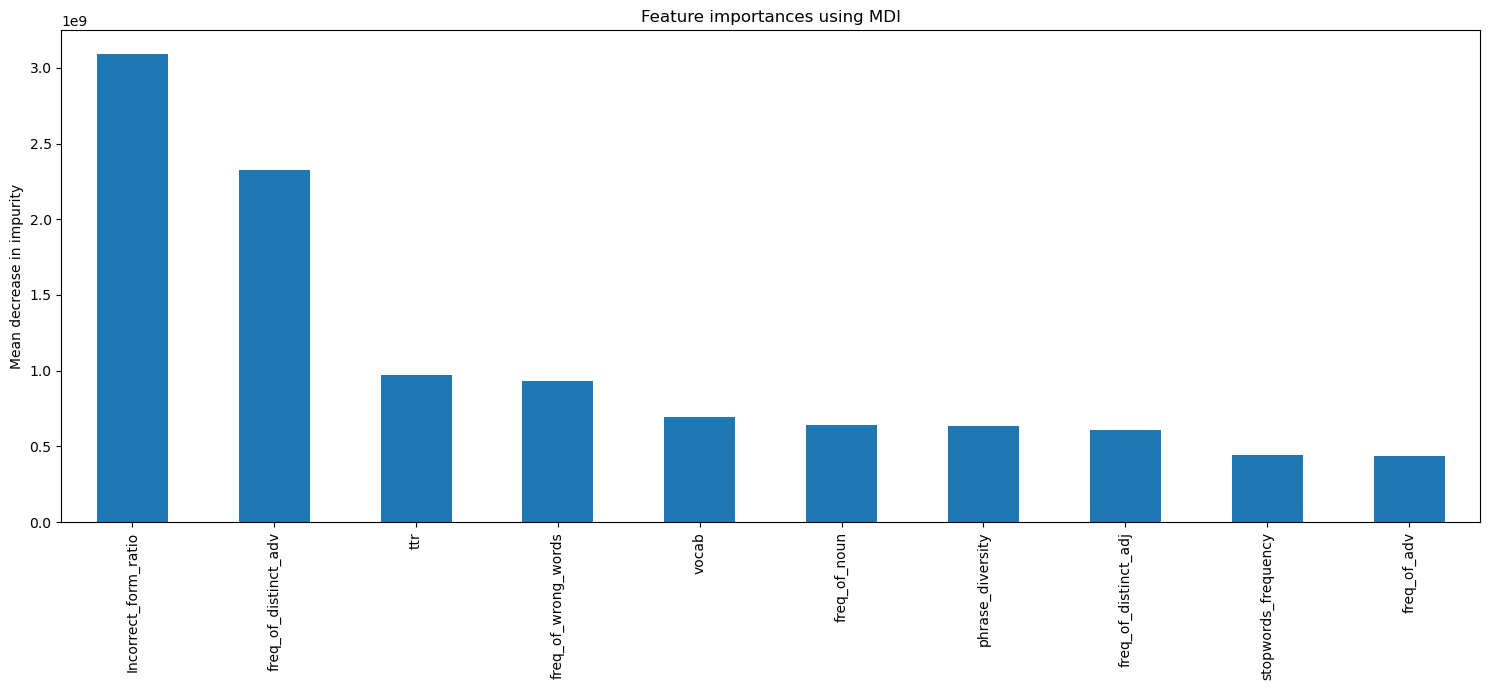

In [63]:
# Feature Importance using MDI
import matplotlib.pyplot as plt
importances = abs(lr.coef_)

forest_importances = pd.Series(importances, index=X_test2.columns.values.tolist()).sort_values(ascending=False)[:10]

fig, ax = plt.subplots(figsize=(15,7))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()